In [34]:
import pandas as pd
import numpy as np


from sklearn.metrics import (f1_score, classification_report, roc_auc_score, confusion_matrix)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import GridSearchCV

import optuna
from optuna.integration import OptunaSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt


In [25]:
df = pd.read_parquet("df_preprocessed.parquet")

train_cycles = ["A1", "B1", "B3"]
val_cycle    = "A2"
test_cycle   = "B2"

df_train = df[df["cycle_id"].isin(train_cycles)].copy()
df_val   = df[df["cycle_id"] == val_cycle].copy()
df_test  = df[df["cycle_id"] == test_cycle].copy()
print(df.keys())

feature_cols_all = [
    
    "delta_p_mean", 
    "delta_p_std",
    "delta_p_trend",
    "output_mean",
    "output_std",
    "output_trend",
    "active_pressure_fraction"

]

X_train = df_train[feature_cols_all]
X_val   = df_val[feature_cols_all]
X_test  = df_test[feature_cols_all]

y_train = df_train["label"]
y_val   = df_val["label"]
y_test  = df_test["label"]



Index(['pump_id', 'end_time', 'label', 'delta_p_mean', 'delta_p_std',
       'delta_p_trend', 'active_pressure_fraction', 'torque_median',
       'torque_std', 'torque_trend', 'output_mean', 'output_std',
       'output_trend', 'suction_mean', 'suction_std', 'discharge_mean',
       'discharge_std', 'flow_primary_mean', 'flow_total_mean',
       'tank_level_mean', 'tank_level_std', 'dm1_mean', 'dm1_std', 'dm2_mean',
       'dm2_std', 'dm3_mean', 'dm3_std', 'pc1_fraction', 'pc2_fraction',
       'pc3_fraction', 'cycle_id'],
      dtype='object')


In [31]:
from sklearn.impute import SimpleImputer

# LR-specific feature matrix

imputer = SimpleImputer(strategy="median")

X_train_lr = imputer.fit_transform(X_train)
X_val_lr = imputer.transform(X_val)
X_test_lr = imputer.transform(X_test)

y_train_lr = y_train.copy()
y_val_lr   = y_val.copy()
y_test_lr  = y_test.copy()



lr_pipe = Pipeline([
    ("scale", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=500,
        class_weight="balanced", 
        solver="lbfgs",
        penalty='l2'
    ))
])

param_grid_lr = {
    "clf__C": [0.01, 0.1, 1, 10, 100],
    "clf__penalty": ["l2"],
    "clf__solver": ["lbfgs"]
}

grid_lr = GridSearchCV(
    lr_pipe,
    param_grid_lr,
    cv=3,
    scoring="f1",
    n_jobs=-1
)

grid_lr.fit(X_train_lr, y_train_lr)

print("Best LR params:", grid_lr.best_params_)

# evaluation
print("Validation performance:")
print(classification_report(y_val_lr, grid_lr.predict(X_val_lr)))
print("ROC-AUC:", roc_auc_score(y_val_lr, grid_lr.predict_proba(X_val_lr)[:,1]))


Best LR params: {'clf__C': 100, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Validation performance:
              precision    recall  f1-score   support

           0       1.00      0.77      0.87      3908
           1       0.16      1.00      0.27       168

    accuracy                           0.78      4076
   macro avg       0.58      0.88      0.57      4076
weighted avg       0.97      0.78      0.84      4076

ROC-AUC: 0.9792473924062973



Permutation Importance (sorted):
                    feature  importance_mean  importance_std
4                output_std         0.241066        0.006497
0              delta_p_mean         0.061425        0.002888
1               delta_p_std         0.018687        0.003483
5              output_trend         0.004386        0.001737
3               output_mean        -0.010107        0.001130
2             delta_p_trend        -0.012744        0.002456
6  active_pressure_fraction        -0.025209        0.003107


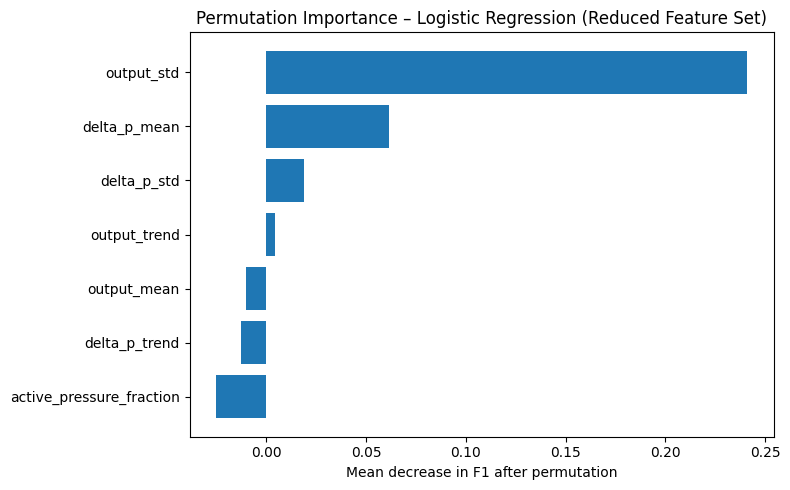

In [35]:
#permutation importance of log res (reduced):


# use best estimator
best_lr_model = grid_lr.best_estimator_

# Compute permutation importance on validation set
perm_result = permutation_importance(
    best_lr_model,
    X_val_lr,         
    y_val_lr,
    n_repeats=50,
    scoring="f1",
    random_state=42
)

#  importance table
importances_lr = pd.DataFrame({
    "feature": feature_cols_all,
    "importance_mean": perm_result.importances_mean,
    "importance_std": perm_result.importances_std
}).sort_values("importance_mean", ascending=False)

print("\nPermutation Importance (sorted):")
print(importances_lr)

# plot
plt.figure(figsize=(8, 5))
plt.barh(importances_lr["feature"], importances_lr["importance_mean"])
plt.xlabel("Mean decrease in F1 after permutation")
plt.title("Permutation Importance – Logistic Regression (Reduced Feature Set)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()





In [40]:
#error analysis on test (log res reduced):
print("=== Logistic Regression — TEST CYCLE (B2) ===")
test_pred = grid_lr.predict(X_test_lr)
test_prob = grid_lr.predict_proba(X_test_lr)[:, 1]

print(classification_report(y_test_lr, test_pred))
print("ROC-AUC:", roc_auc_score(y_test_lr, test_prob))
print("Confusion matrix:\n", confusion_matrix(y_test_lr, test_pred))



=== Logistic Regression — TEST CYCLE (B2) ===
              precision    recall  f1-score   support

           0       0.95      0.86      0.90      3384
           1       0.02      0.05      0.03       168

    accuracy                           0.83      3552
   macro avg       0.48      0.46      0.46      3552
weighted avg       0.90      0.83      0.86      3552

ROC-AUC: 0.65133189800743
Confusion matrix:
 [[2924  460]
 [ 160    8]]


In [42]:
#robustness check on test (log res reduced)

def run_cross_line(train_lines, test_lines):

    df_train_CL = df[(df["pump_id"].isin(train_lines)) & (df["cycle_id"] != "B2")]
    df_test_CL  = df[(df["pump_id"].isin(test_lines))  & (df["cycle_id"] == "B2")]

    #  if test set empty, skip (because error)
    if df_test_CL.shape[0] == 0:
        return None, None

    X_tr = df_train_CL[feature_cols_all]
    y_tr = df_train_CL["label"]

    X_te = df_test_CL[feature_cols_all]
    y_te = df_test_CL["label"]

    # Impute and scale
    X_tr_imp = imputer.fit_transform(X_tr)
    X_te_imp = imputer.transform(X_te)

    # Retrain 
    lr_cl = Pipeline([
        ("scale", StandardScaler()),
        ("clf", LogisticRegression(
            C=grid_lr.best_params_["clf__C"],
            max_iter=500,
            class_weight="balanced",
            solver="lbfgs",
            penalty="l2"
        ))
    ])

    lr_cl.fit(X_tr_imp, y_tr)
    preds = lr_cl.predict(X_te_imp)
    prob  = lr_cl.predict_proba(X_te_imp)[:, 1]

    return classification_report(y_te, preds, output_dict=True), roc_auc_score(y_te, prob)


# TRY BOTH !
report_A_B, auc_A_B = run_cross_line(train_lines=["A"], test_lines=["B"])
report_B_A, auc_B_A = run_cross_line(train_lines=["B"], test_lines=["A"])

print("\n=== Cross-Line Generalization ===")
print("Train A → Test B:", 
      "F1:", report_A_B["1"]["f1-score"], "| AUC:", auc_A_B)

if report_B_A is None:
    print("Train B → Test A: Not possible (no B2 samples for pump A)")
else:
    print("Train B → Test A:", 
          "F1:", report_B_A["1"]["f1-score"], "| AUC:", auc_B_A)




=== Cross-Line Generalization ===
Train A → Test B: F1: 0.0 | AUC: 0.4255547816053135
Train B → Test A: Not possible (no B2 samples for pump A)


In [37]:
#Random forest

from sklearn.impute import SimpleImputer

torque_imputer = SimpleImputer(strategy="median")

X_train_sup = torque_imputer.fit_transform(X_train)
X_val_sup   = torque_imputer.transform(X_val)
X_test_sup  = torque_imputer.transform(X_test)

# Rr
rf_pipe = Pipeline([
    ("clf", RandomForestClassifier(
        random_state=42,
        n_jobs=-1,
        class_weight="balanced"   
    ))
])


# Optuna search space 
rf_param_distributions = {
    "clf__n_estimators": optuna.distributions.IntDistribution(200, 600),
    "clf__max_depth": optuna.distributions.IntDistribution(3, 20),
    "clf__min_samples_split": optuna.distributions.IntDistribution(2, 10),
    "clf__min_samples_leaf": optuna.distributions.IntDistribution(1, 4),
    "clf__max_features": optuna.distributions.CategoricalDistribution(["sqrt", "log2"]),
}
# Optuna runs
rf_search = OptunaSearchCV(
    estimator=rf_pipe,
    param_distributions=rf_param_distributions,
    n_trials=40,
    scoring="f1",
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Fit
rf_search.fit(X_train_sup, y_train)

print("Best RF Params:", rf_search.best_params_)

# evaluation
rf_pred_val = rf_search.predict(X_val_sup)
print("\nValidation Performance:")
print(classification_report(y_val, rf_pred_val))

if hasattr(rf_search, "predict_proba"):
    print("Validation ROC-AUC:",
          roc_auc_score(y_val, rf_search.predict_proba(X_val_sup)[:,1]))


/var/folders/4d/4htwx0b53_s1x9dcz_dvsbnw0000gn/T/ipykernel_91156/591759741.py:33: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  rf_search = OptunaSearchCV(
[I 2025-12-01 15:26:45,416] A new study created in memory with name: no-name-a17ced00-8d40-4c77-b08a-6f0a09650348
[I 2025-12-01 15:26:53,221] Trial 6 finished with value: 0.11791048448611008 and parameters: {'clf__n_estimators': 233, 'clf__max_depth': 13, 'clf__min_samples_split': 10, 'clf__min_samples_leaf': 2, 'clf__max_features': 'sqrt'}. Best is trial 6 with value: 0.11791048448611008.
[I 2025-12-01 15:26:54,036] Trial 0 finished with value: 0.12043960217427425 and parameters: {'clf__n_estimators': 246, 'clf__max_depth': 7, 'clf__min_samples_split': 9, 'clf__min_samples_leaf': 4, 'clf__max_features': 'sqrt'}. Best is trial 0 with value: 0.12043960217427425.
[I 2025-12-01 15:26:55,677] Trial 7 finished with value: 0.11815597577555308 and parameters: {'clf__

Best RF Params: {'clf__n_estimators': 390, 'clf__max_depth': 3, 'clf__min_samples_split': 7, 'clf__min_samples_leaf': 3, 'clf__max_features': 'log2'}

Validation Performance:
              precision    recall  f1-score   support

           0       0.96      0.91      0.94      3908
           1       0.09      0.20      0.13       168

    accuracy                           0.88      4076
   macro avg       0.53      0.56      0.53      4076
weighted avg       0.93      0.88      0.90      4076

Validation ROC-AUC: 0.8053496795340449


In [27]:
#XGBoost

from sklearn.impute import SimpleImputer

torque_imputer = SimpleImputer(strategy="median")

X_train_sup = torque_imputer.fit_transform(X_train)
X_val_sup   = torque_imputer.transform(X_val)
X_test_sup  = torque_imputer.transform(X_test)



# imbalance ratio
pos = sum(y_train == 1)
neg = sum(y_train == 0)
scale_pos_weight = neg / pos
print("scale_pos_weight =", scale_pos_weight)

# Pipeline xgb with imbalance ratio:
pipe_xgb = Pipeline([
    ("clf", XGBClassifier(
        tree_method="hist",
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=42,
        scale_pos_weight=scale_pos_weight   
    ))
])


# Optuna search space
def objective(trial):

    params = {
        "clf__n_estimators": trial.suggest_int("n_estimators", 200, 600),
        "clf__learning_rate": trial.suggest_float("learning_rate", 0.01, 0.10),
        "clf__max_depth": trial.suggest_int("max_depth", 2, 10),
        "clf__subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "clf__colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "clf__min_child_weight": trial.suggest_int("min_child_weight", 1, 5),
    }

    model = pipe_xgb.set_params(**params)

    model.fit(X_train_sup, y_train)

    preds = model.predict(X_val_sup)
    return f1_score(y_val, preds, zero_division=0)



#  Optuna run

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40)

best_params = study.best_params
print("Best XGB Params:", best_params)


# Fit model
pipe_xgb_best = pipe_xgb.set_params(**{
    f"clf__{k}": v for k, v in best_params.items()
})

pipe_xgb_best.fit(X_train_sup, y_train)

# Evaluation
xgb_preds = pipe_xgb_best.predict(X_val_sup)

print("\nValidation F1:", f1_score(y_val, xgb_preds))
print("Validation ROC-AUC:",
      roc_auc_score(y_val, pipe_xgb_best.predict_proba(X_val_sup)[:,1]))


[I 2025-12-01 10:50:15,128] A new study created in memory with name: no-name-282aabae-5394-4107-8494-b1085acf741e
[I 2025-12-01 10:50:15,258] Trial 0 finished with value: 0.022922636103151862 and parameters: {'n_estimators': 258, 'learning_rate': 0.022497137801506254, 'max_depth': 3, 'subsample': 0.6801739860502319, 'colsample_bytree': 0.8742457475642381, 'min_child_weight': 1}. Best is trial 0 with value: 0.022922636103151862.


scale_pos_weight = 24.94047619047619


[I 2025-12-01 10:50:15,591] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 581, 'learning_rate': 0.043736772994035895, 'max_depth': 6, 'subsample': 0.6032055461645537, 'colsample_bytree': 0.7706634609282977, 'min_child_weight': 1}. Best is trial 0 with value: 0.022922636103151862.
[I 2025-12-01 10:50:15,802] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 353, 'learning_rate': 0.06558158959122226, 'max_depth': 8, 'subsample': 0.7628963366187343, 'colsample_bytree': 0.9987721855641364, 'min_child_weight': 4}. Best is trial 0 with value: 0.022922636103151862.
[I 2025-12-01 10:50:16,066] Trial 3 finished with value: 0.0 and parameters: {'n_estimators': 395, 'learning_rate': 0.04888744876065919, 'max_depth': 8, 'subsample': 0.7335570709779329, 'colsample_bytree': 0.6861351155524179, 'min_child_weight': 5}. Best is trial 0 with value: 0.022922636103151862.
[I 2025-12-01 10:50:16,264] Trial 4 finished with value: 0.03529411764705882 and parameters: {'n_es

Best XGB Params: {'n_estimators': 488, 'learning_rate': 0.05690846737927404, 'max_depth': 2, 'subsample': 0.8303895289397836, 'colsample_bytree': 0.8110421192769196, 'min_child_weight': 3}

Validation F1: 0.11267605633802817
Validation ROC-AUC: 0.7334359921041087


In [32]:
#validation scores

print("===== LOGISTIC REGRESSION — Validation =====")
val_pred_lr = grid_lr.predict(X_val_lr)
val_prob_lr = grid_lr.predict_proba(X_val_lr)[:, 1]

print(classification_report(y_val, val_pred_lr))
print("ROC-AUC:", roc_auc_score(y_val, val_prob_lr))
print("Confusion matrix:\n", confusion_matrix(y_val, val_pred_lr))


print("\n===== RANDOM FOREST — Validation =====")
val_pred_rf = rf_search.predict(X_val_sup)
val_prob_rf = rf_search.predict_proba(X_val_sup)[:, 1]

print(classification_report(y_val, val_pred_rf))
print("ROC-AUC:", roc_auc_score(y_val, val_prob_rf))
print("Confusion matrix:\n", confusion_matrix(y_val, val_pred_rf))


print("\n===== XGBOOST — Validation =====")
val_pred_xgb = pipe_xgb_best.predict(X_val_sup)
val_prob_xgb = pipe_xgb_best.predict_proba(X_val_sup)[:, 1]

print(classification_report(y_val, val_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_val, val_prob_xgb))
print("Confusion matrix:\n", confusion_matrix(y_val, val_pred_xgb))


===== LOGISTIC REGRESSION — Validation =====
              precision    recall  f1-score   support

           0       1.00      0.77      0.87      3908
           1       0.16      1.00      0.27       168

    accuracy                           0.78      4076
   macro avg       0.58      0.88      0.57      4076
weighted avg       0.97      0.78      0.84      4076

ROC-AUC: 0.9792473924062973
Confusion matrix:
 [[3003  905]
 [   0  168]]

===== RANDOM FOREST — Validation =====
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      3908
           1       0.09      0.20      0.13       168

    accuracy                           0.89      4076
   macro avg       0.53      0.56      0.53      4076
weighted avg       0.93      0.89      0.91      4076

ROC-AUC: 0.7910414229663206
Confusion matrix:
 [[3576  332]
 [ 134   34]]

===== XGBOOST — Validation =====
              precision    recall  f1-score   support

           0       0.96 

In [33]:
#test scores: 

print("===== LOGISTIC REGRESSION — Test =====")
test_pred_lr = grid_lr.predict(X_test_lr)
test_prob_lr = grid_lr.predict_proba(X_test_lr)[:, 1]

print(classification_report(y_test, test_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, test_prob_lr))
print("Confusion matrix:\n", confusion_matrix(y_test, test_pred_lr))


print("\n===== RANDOM FOREST — Test =====")
test_pred_rf = rf_search.predict(X_test_sup)
test_prob_rf = rf_search.predict_proba(X_test_sup)[:, 1]

print(classification_report(y_test, test_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, test_prob_rf))
print("Confusion matrix:\n", confusion_matrix(y_test, test_pred_rf))


print("\n===== XGBOOST — Test =====")
test_pred_xgb = pipe_xgb_best.predict(X_test_sup)
test_prob_xgb = pipe_xgb_best.predict_proba(X_test_sup)[:, 1]

print(classification_report(y_test, test_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, test_prob_xgb))
print("Confusion matrix:\n", confusion_matrix(y_test, test_pred_xgb))


===== LOGISTIC REGRESSION — Test =====
              precision    recall  f1-score   support

           0       0.95      0.86      0.90      3384
           1       0.02      0.05      0.03       168

    accuracy                           0.83      3552
   macro avg       0.48      0.46      0.46      3552
weighted avg       0.90      0.83      0.86      3552

ROC-AUC: 0.65133189800743
Confusion matrix:
 [[2924  460]
 [ 160    8]]

===== RANDOM FOREST — Test =====
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      3384
           1       0.00      0.00      0.00       168

    accuracy                           0.88      3552
   macro avg       0.47      0.46      0.47      3552
weighted avg       0.90      0.88      0.89      3552

ROC-AUC: 0.015176460655184075
Confusion matrix:
 [[3137  247]
 [ 168    0]]

===== XGBOOST — Test =====
              precision    recall  f1-score   support

           0       0.95      0.93      0.9